In [5]:
import os
import urllib.request
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline

from amlutils import blobs_util as b_util
import mnist_util as m_util
import mnist_train as m_train

The blobs_util module relies on the access credentials for the remote blob storage to be in the following environment variables. We use dotenv to conveniently load them, along with the configuration of the local data folder paths, from the .env file in the project root:

    ACCOUNT_NAME=<STORAGE ACCOUNT NAME>
    
    ACCOUNT_ACCESS_KEY=<STORAGE ACCOUNT ACCESS KEY>

    IS_EMULATED=False
    
    DATA_LOCAL=<FOLDER PATH TO HOLD DATA>
    
    OUTPUT_LOCAL=<FOLDER FOR THE PRODUCED OUTPUT>

In [27]:
load_dotenv()

True

# Image Classification Model based on MNIST dataset
## Local Execution

Based on Azure official tutorial https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-train-models-with-aml. See also: 
* https://github.com/Azure/MachineLearningNotebooks/tree/master/tutorials
* https://github.com/piizei/mlops.git

In this notebook, we start from the data in a remote blob storage, download it and explore it locally. The following notebook then demonstrates how to push any computationally heavier task to a remote compute on the Azure Machine Learning Workspace (AMLWS).

### Download the Data
Any AMLWS also comes with a default storage, but I usually want to keep the data separate so that I do not have to worry about it once I am done with the calculations and want to destroy the workspace. Therefore the first step is to download the data from the corresponding Azure Storage account. The credentials to the storage account have to be loaded into the environment variables as shown above. The container is called 'mnist' in my case:

In [ ]:
data_folder = os.getenv('DATA_LOCAL')
print(data_folder)

In [21]:
container_name = 'mnist'
os.makedirs(data_folder, exist_ok=True)

for fn in b_util.list_blobs_in_container(container_name):
    b_util.get_file_blob_to_path(container_name, fn, os.path.join(data_folder, fn))

In case you want to download it directly:

### Inspect the Data

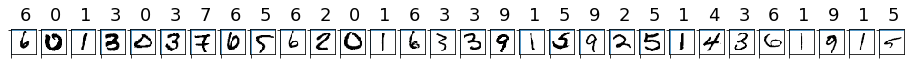

In [25]:
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = m_util.load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = m_util.load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = m_util.load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = m_util.load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 30
plt.figure(figsize=(16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

### Train the Model
We put the code to train the model into a separate script. The point here is that we can use the same code for training the model locally (perhaps with a smaller training set, limited number of iterations etc.) as on the remote compute.

In [31]:
output_folder = os.getenv('OUTPUT_LOCAL')
os.makedirs(output_folder, exist_ok=True)

In [32]:
model_output_fp = os.path.join(output_folder, 'sklearn_mnist_model.pkl')

In [ ]:
clf = m_train.train(data_folder,0.01,model_output_fp)

### Plot Results

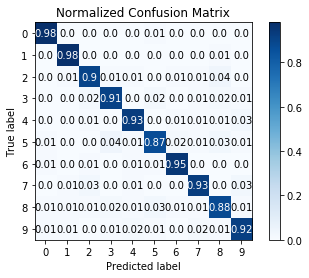

In [34]:
skplt.metrics.plot_confusion_matrix(y_test, clf.predict(X_test), normalize=True)
plt.show()